# Runtime Comparison between different Data Valuation methods

Run all methods we used on classification with different number of data points. 

In [ ]:
import os
import time

import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from opendataval.dataloader import DataFetcher
from opendataval.dataval import RandomEvaluator, KNNShapley, LavaEvaluator
from opendataval.model import ClassifierMLP

from src.baseline.MLP_hyperparameters import CLASSIFIER_MLP_HYPERPARAMETERS
from src.baseline.utils import instantiate_evaluators
from src.LossVal.LossVal_MLP import LossVal_MLP
from src.LossVal.LossVal_evaluator import LossVal_Evaluator
from src.LossVal.loss_configurations import CLASSIFICATION_LOSSES

os.environ["TQDM_DISABLE"] = "True"

In [2]:
DATA_DIR = os.path.join("../../data_files/")

DATASET = "pol"
NR_OF_DATAPOINTS = [1000, 100]   #[10, 50, 100, 1000]
TRAINING_EPOCHS = 5
NR_REPETITIONS = 5

MLP_HYPERPARAM = CLASSIFIER_MLP_HYPERPARAMETERS
LOSSVAL_LOSS = CLASSIFICATION_LOSSES["Weighted CE loss with squared Sinkhorn"]

HIDDEN_DIM_SIZE = CLASSIFIER_MLP_HYPERPARAMETERS["hidden_dim"]
NUM_LAYERS = CLASSIFIER_MLP_HYPERPARAMETERS["layers"]
ACTIVATION_FUNCTION = CLASSIFIER_MLP_HYPERPARAMETERS["act_fn"]

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", DEVICE)

Using device: cuda


In [3]:
timing_df = pd.DataFrame(columns=["method", "nr samples", "time (s)"])

In [4]:
def run_one(evaluator, X_train, y_train, X_val, y_val, use_lossval, device, nr_epochs=5):
    if use_lossval:
        evaluator.input_data(X_train, y_train, X_val, y_val)
        model = LossVal_MLP(
            hidden_dim=HIDDEN_DIM_SIZE, layers=NUM_LAYERS, act_fn=ACTIVATION_FUNCTION, input_dim=X_train.shape[1], 
            output_dim=y_val.shape[1], is_classification=True, training_set_size=y_train.shape[0]
        ).to(device)
        evaluator.input_model(model)
        
    else:    
        if not any(isinstance(evaluator, x) for x in [KNNShapley, LavaEvaluator]):
            evaluator.input_data(X_train, y_train, X_val, y_val) 
            evaluator.input_model(
                ClassifierMLP(hidden_dim=HIDDEN_DIM_SIZE, layers=NUM_LAYERS, act_fn=ACTIVATION_FUNCTION,
                              input_dim=X_train.shape[1], num_classes=y_val.shape[1]).to(device)
            )
        else:
            evaluator.input_data(X_train.clone().detach().cpu(),
                                 y_train.clone().detach().cpu(),
                                 X_val.clone().detach().cpu(),
                                 y_val.clone().detach().cpu())
        evaluator.metric = lambda a, b: F.cross_entropy(a, b).item()  # InfluenceSubsample requires this

    start_time = time.time()
    evaluator.train_data_values(epochs=nr_epochs)
    end_time = time.time()

    return end_time - start_time 

In [5]:
from opendataval.dataval import DVRL

for nr_datapoints in NR_OF_DATAPOINTS:
    print(f"Evaluate for {nr_datapoints} datapoints")
    for i in range(NR_REPETITIONS):
        data_fetcher = DataFetcher(dataset_name=DATASET, cache_dir=DATA_DIR, force_download=True)
        data_fetcher = data_fetcher.split_dataset_by_count(nr_datapoints, 100, 500)
        X_train, y_train, X_val, y_val, _, _ = data_fetcher.datapoints
        # X_train, y_train, X_val, y_val = X_train.to(DEVICE), y_train.to(DEVICE), X_val.to(DEVICE), y_val.to(DEVICE)     

        baseline_evaluators = instantiate_evaluators(100, nr_models=nr_datapoints, rl_epochs=2*nr_datapoints)
        baseline_evaluators = [evaluator for evaluator in baseline_evaluators if not isinstance(evaluator, RandomEvaluator)]

        for evaluator in baseline_evaluators:
            print(f"  Training valuation model: {evaluator.__class__.__name__}")
            evaluator.device = DEVICE
            timing = run_one(evaluator, X_train, y_train, X_val, y_val, False, DEVICE)
            timing_df = pd.concat([timing_df, pd.DataFrame({"method": [evaluator], "nr samples": [nr_datapoints], "time (s)": [timing]})], ignore_index=True)

        lossval_eval = LossVal_Evaluator(DEVICE, LOSSVAL_LOSS, nr_epochs=5)
        timing = run_one(lossval_eval, X_train, y_train, X_val, y_val, True, DEVICE, 5)
        timing_df = pd.concat([timing_df, pd.DataFrame({"method": ["LossVal (epochs=5)"], "nr samples": [nr_datapoints], "time (s)": [timing]})], ignore_index=True)

        lossval_eval = LossVal_Evaluator(DEVICE, LOSSVAL_LOSS, nr_epochs=30)
        timing = run_one(lossval_eval, X_train, y_train, X_val, y_val, True, DEVICE, 30)
        timing_df = pd.concat([timing_df, pd.DataFrame({"method": ["LossVal (epochs=30)"], "nr samples": [nr_datapoints], "time (s)": [timing]})], ignore_index=True)

Evaluate for 1000 datapoints
  Training valuation model: InfluenceSubsample


100%|██████████| 1000/1000 [02:52<00:00,  5.80it/s]


  Training valuation model: LeaveOneOut


100%|██████████| 1000/1000 [04:04<00:00,  4.09it/s]

  Training valuation model: DataShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


gr_stat=100


100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.01it/s]

gr_stat=1.0127671778358125
Done: marginal contribution computation
  Training valuation model: BetaShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


gr_stat=100


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


gr_stat=100


100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


gr_stat=100


100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


gr_stat=100


100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.54it/s]

gr_stat=1.012912308323986
Done: marginal contribution computation


  Training valuation model: DataBanzhaf


100%|██████████| 1000/1000 [02:06<00:00,  7.91it/s]


  Training valuation model: DataOob


100%|██████████| 1000/1000 [04:03<00:00,  4.11it/s]


  Training valuation model: AME


100%|██████████| 1000/1000 [03:14<00:00,  5.14it/s]


  Training valuation model: DVRL


100%|██████████| 2000/2000 [00:31<00:00, 63.30it/s]


  Training valuation model: KNNShapley


100%|██████████| 999/999 [00:00<00:00, 8324.97it/s]


  Training valuation model: LavaEvaluator


  Training valuation model: InfluenceSubsample


100%|██████████| 1000/1000 [02:51<00:00,  5.84it/s]


  Training valuation model: LeaveOneOut


100%|██████████| 1000/1000 [04:03<00:00,  4.11it/s]

  Training valuation model: DataShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:16<00:00,  6.14it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


gr_stat=100


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]

gr_stat=1.0098641767648266
Done: marginal contribution computation
  Training valuation model: BetaShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.57it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


gr_stat=100


100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.08it/s]

gr_stat=1.0084481576234787
Done: marginal contribution computation


  Training valuation model: DataBanzhaf


100%|██████████| 1000/1000 [02:06<00:00,  7.88it/s]


  Training valuation model: DataOob


100%|██████████| 1000/1000 [04:05<00:00,  4.08it/s]


  Training valuation model: AME


100%|██████████| 1000/1000 [03:16<00:00,  5.09it/s]


  Training valuation model: DVRL


100%|██████████| 2000/2000 [00:32<00:00, 62.38it/s]


  Training valuation model: KNNShapley


100%|██████████| 999/999 [00:00<00:00, 8325.06it/s]


  Training valuation model: LavaEvaluator


  Training valuation model: InfluenceSubsample


100%|██████████| 1000/1000 [02:51<00:00,  5.84it/s]


  Training valuation model: LeaveOneOut


100%|██████████| 1000/1000 [04:04<00:00,  4.08it/s]

  Training valuation model: DataShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.61it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


gr_stat=100


100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]

gr_stat=1.0116261194055707
Done: marginal contribution computation
  Training valuation model: BetaShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


gr_stat=100


100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


gr_stat=100


100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


gr_stat=100


100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


gr_stat=100


100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.30it/s]

gr_stat=1.0080713254370994
Done: marginal contribution computation


  Training valuation model: DataBanzhaf


100%|██████████| 1000/1000 [02:07<00:00,  7.85it/s]


  Training valuation model: DataOob


100%|██████████| 1000/1000 [04:05<00:00,  4.07it/s]


  Training valuation model: AME


100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s]


  Training valuation model: DVRL


100%|██████████| 2000/2000 [00:32<00:00, 61.79it/s]


  Training valuation model: KNNShapley


100%|██████████| 999/999 [00:00<00:00, 7744.19it/s]


  Training valuation model: LavaEvaluator


  Training valuation model: InfluenceSubsample


100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


  Training valuation model: LeaveOneOut


100%|██████████| 1000/1000 [04:05<00:00,  4.08it/s]

  Training valuation model: DataShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


gr_stat=100


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]

gr_stat=1.0093078523911998
Done: marginal contribution computation
  Training valuation model: BetaShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


gr_stat=100


100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


gr_stat=100


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


gr_stat=100


100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


gr_stat=100


100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


gr_stat=100


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]

gr_stat=1.0108132106791026
Done: marginal contribution computation


  Training valuation model: DataBanzhaf


100%|██████████| 1000/1000 [02:07<00:00,  7.87it/s]


  Training valuation model: DataOob


100%|██████████| 1000/1000 [04:05<00:00,  4.08it/s]


  Training valuation model: AME


100%|██████████| 1000/1000 [03:15<00:00,  5.10it/s]


  Training valuation model: DVRL


100%|██████████| 2000/2000 [00:31<00:00, 63.09it/s]


  Training valuation model: KNNShapley


100%|██████████| 999/999 [00:00<00:00, 8122.02it/s]


  Training valuation model: LavaEvaluator


  Training valuation model: InfluenceSubsample


100%|██████████| 1000/1000 [02:52<00:00,  5.80it/s]


  Training valuation model: LeaveOneOut


100%|██████████| 1000/1000 [04:05<00:00,  4.08it/s]

  Training valuation model: DataShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


gr_stat=100


100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


gr_stat=100


100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


gr_stat=100


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


gr_stat=100


100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.74it/s]

gr_stat=1.0100798367171062
Done: marginal contribution computation
  Training valuation model: BetaShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


gr_stat=100


100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


gr_stat=100


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


gr_stat=100


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


gr_stat=100


100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


gr_stat=100


100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


gr_stat=100


100%|██████████| 100/100 [00:27<00:00,  3.60it/s]


gr_stat=100


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


gr_stat=100


100%|██████████| 100/100 [00:24<00:00,  4.12it/s]

gr_stat=1.0087465911236857
Done: marginal contribution computation


  Training valuation model: DataBanzhaf


100%|██████████| 1000/1000 [02:07<00:00,  7.82it/s]


  Training valuation model: DataOob


100%|██████████| 1000/1000 [04:06<00:00,  4.05it/s]


  Training valuation model: AME


100%|██████████| 1000/1000 [03:25<00:00,  4.88it/s]


  Training valuation model: DVRL


100%|██████████| 2000/2000 [00:33<00:00, 60.41it/s]


  Training valuation model: KNNShapley


100%|██████████| 999/999 [00:00<00:00, 8056.45it/s]


  Training valuation model: LavaEvaluator


Evaluate for 100 datapoints
  Training valuation model: InfluenceSubsample


100%|██████████| 100/100 [00:02<00:00, 38.01it/s]


  Training valuation model: LeaveOneOut


100%|██████████| 100/100 [00:03<00:00, 29.27it/s]

  Training valuation model: DataShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


gr_stat=100


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


gr_stat=100


100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


gr_stat=100


100%|██████████| 100/100 [00:37<00:00,  2.65it/s]


gr_stat=100


100%|██████████| 100/100 [00:34<00:00,  2.86it/s]


gr_stat=100


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


gr_stat=100


100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


gr_stat=100


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


gr_stat=100


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


gr_stat=100


100%|██████████| 100/100 [00:37<00:00,  2.69it/s]

gr_stat=1.0070312878958663
Done: marginal contribution computation
  Training valuation model: BetaShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


gr_stat=100


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


gr_stat=100


100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


gr_stat=100


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


gr_stat=100


100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


gr_stat=100


100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


gr_stat=100


100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


gr_stat=100


100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


gr_stat=100


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


gr_stat=100


100%|██████████| 100/100 [00:33<00:00,  2.97it/s]

gr_stat=1.0055661871292945
Done: marginal contribution computation


  Training valuation model: DataBanzhaf


100%|██████████| 100/100 [00:01<00:00, 54.17it/s]


  Training valuation model: DataOob


100%|██████████| 100/100 [00:03<00:00, 31.12it/s]


  Training valuation model: AME


100%|██████████| 100/100 [00:02<00:00, 37.13it/s]


  Training valuation model: DVRL


100%|██████████| 200/200 [00:03<00:00, 60.64it/s]


  Training valuation model: KNNShapley


100%|██████████| 99/99 [00:00<00:00, 7071.22it/s]


  Training valuation model: LavaEvaluator


  Training valuation model: InfluenceSubsample


100%|██████████| 100/100 [00:02<00:00, 38.28it/s]


  Training valuation model: LeaveOneOut


100%|██████████| 100/100 [00:03<00:00, 28.50it/s]

  Training valuation model: DataShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


gr_stat=100


100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


gr_stat=100


100%|██████████| 100/100 [00:15<00:00,  6.25it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


gr_stat=100


100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.74it/s]

gr_stat=1.0064279357855563
Done: marginal contribution computation
  Training valuation model: BetaShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


gr_stat=100


100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  5.90it/s]

gr_stat=1.0064315398357833
Done: marginal contribution computation


  Training valuation model: DataBanzhaf


100%|██████████| 100/100 [00:01<00:00, 50.05it/s]


  Training valuation model: DataOob


100%|██████████| 100/100 [00:03<00:00, 30.76it/s]


  Training valuation model: AME


100%|██████████| 100/100 [00:02<00:00, 35.47it/s]


  Training valuation model: DVRL


100%|██████████| 200/200 [00:03<00:00, 57.72it/s]


  Training valuation model: KNNShapley


100%|██████████| 99/99 [00:00<00:00, 6600.06it/s]


  Training valuation model: LavaEvaluator


  Training valuation model: InfluenceSubsample


100%|██████████| 100/100 [00:02<00:00, 37.76it/s]


  Training valuation model: LeaveOneOut


100%|██████████| 100/100 [00:03<00:00, 28.96it/s]

  Training valuation model: DataShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


gr_stat=100


100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


gr_stat=100


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


gr_stat=100


100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


gr_stat=100


100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


gr_stat=100


100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


gr_stat=100


100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


gr_stat=100


100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


gr_stat=100


100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


gr_stat=100


100%|██████████| 100/100 [00:26<00:00,  3.77it/s]

gr_stat=1.009029348269187
Done: marginal contribution computation
  Training valuation model: BetaShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


gr_stat=100


100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


gr_stat=100


100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


gr_stat=100


100%|██████████| 100/100 [00:29<00:00,  3.36it/s]


gr_stat=100


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


gr_stat=100


100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


gr_stat=100


100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


gr_stat=100


100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


gr_stat=100


100%|██████████| 100/100 [00:29<00:00,  3.33it/s]


gr_stat=100


100%|██████████| 100/100 [00:28<00:00,  3.51it/s]

gr_stat=1.010703652241593
Done: marginal contribution computation


  Training valuation model: DataBanzhaf


100%|██████████| 100/100 [00:01<00:00, 53.62it/s]


  Training valuation model: DataOob


100%|██████████| 100/100 [00:03<00:00, 31.06it/s]


  Training valuation model: AME


100%|██████████| 100/100 [00:02<00:00, 37.16it/s]


  Training valuation model: DVRL


100%|██████████| 200/200 [00:03<00:00, 61.46it/s]


  Training valuation model: KNNShapley


100%|██████████| 99/99 [00:00<00:00, 7615.38it/s]


  Training valuation model: LavaEvaluator


  Training valuation model: InfluenceSubsample


100%|██████████| 100/100 [00:02<00:00, 36.18it/s]


  Training valuation model: LeaveOneOut


100%|██████████| 100/100 [00:03<00:00, 28.62it/s]

  Training valuation model: DataShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.68it/s]

gr_stat=1.0088678162230127
Done: marginal contribution computation
  Training valuation model: BetaShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


gr_stat=100


100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


gr_stat=100


100%|██████████| 100/100 [00:16<00:00,  6.13it/s]

gr_stat=1.0062519024825558
Done: marginal contribution computation


  Training valuation model: DataBanzhaf


100%|██████████| 100/100 [00:01<00:00, 51.26it/s]


  Training valuation model: DataOob


100%|██████████| 100/100 [00:03<00:00, 30.89it/s]


  Training valuation model: AME


100%|██████████| 100/100 [00:02<00:00, 36.82it/s]


  Training valuation model: DVRL


100%|██████████| 200/200 [00:03<00:00, 61.79it/s]


  Training valuation model: KNNShapley


100%|██████████| 99/99 [00:00<00:00, 6600.06it/s]


  Training valuation model: LavaEvaluator


  Training valuation model: InfluenceSubsample


100%|██████████| 100/100 [00:02<00:00, 37.82it/s]


  Training valuation model: LeaveOneOut


100%|██████████| 100/100 [00:03<00:00, 28.66it/s]

  Training valuation model: DataShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


gr_stat=100


100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


gr_stat=100


100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


gr_stat=100


100%|██████████| 100/100 [00:19<00:00,  5.08it/s]

gr_stat=1.0072812049165845
Done: marginal contribution computation
  Training valuation model: BetaShapley
Start: marginal contribution computation



100%|██████████| 100/100 [00:21<00:00,  4.76it/s]


gr_stat=100


100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


gr_stat=100


100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


gr_stat=100


100%|██████████| 100/100 [00:23<00:00,  4.28it/s]


gr_stat=100


100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


gr_stat=100


100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


gr_stat=100


100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


gr_stat=100


100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


gr_stat=100


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


gr_stat=100


100%|██████████| 100/100 [00:23<00:00,  4.21it/s]

gr_stat=1.0085250995936217
Done: marginal contribution computation


  Training valuation model: DataBanzhaf


100%|██████████| 100/100 [00:01<00:00, 53.42it/s]


  Training valuation model: DataOob


100%|██████████| 100/100 [00:03<00:00, 30.54it/s]


  Training valuation model: AME


100%|██████████| 100/100 [00:02<00:00, 36.46it/s]


  Training valuation model: DVRL


100%|██████████| 200/200 [00:03<00:00, 57.29it/s]


  Training valuation model: KNNShapley


100%|██████████| 99/99 [00:00<00:00, 5500.03it/s]


  Training valuation model: LavaEvaluator


In [6]:
timing_df

,method,nr samples,time (s)
0,InfluenceSubsample(num_models=1000),1000,172.306000
1,LeaveOneOut(),1000,244.794999
2,DataShapley(cache_name=cached_836888),1000,204.056729
3,BetaShapley(cache_name=cached_836889),1000,197.795999
4,DataBanzhaf(num_models=1000),1000,126.500072
...,...,...,...
115,DVRL(rl_epochs=200),100,3.606998
116,KNNShapley(k_neighbors=100),100,0.024000
117,LavaEvaluator(),100,0.063000
118,LossVal (epochs=5),100,0.270001


In [7]:
timing_df["method"] = timing_df["method"].apply(lambda x: x.__class__.__name__ if not isinstance(x, str) else x)
timing_df.to_csv("../../results/runtime_comparison.csv", index=False)

([<matplotlib.axis.XTick at 0x2f3e2039550>,
 [Text(1000, 0, '1000'), Text(100, 0, '100')])

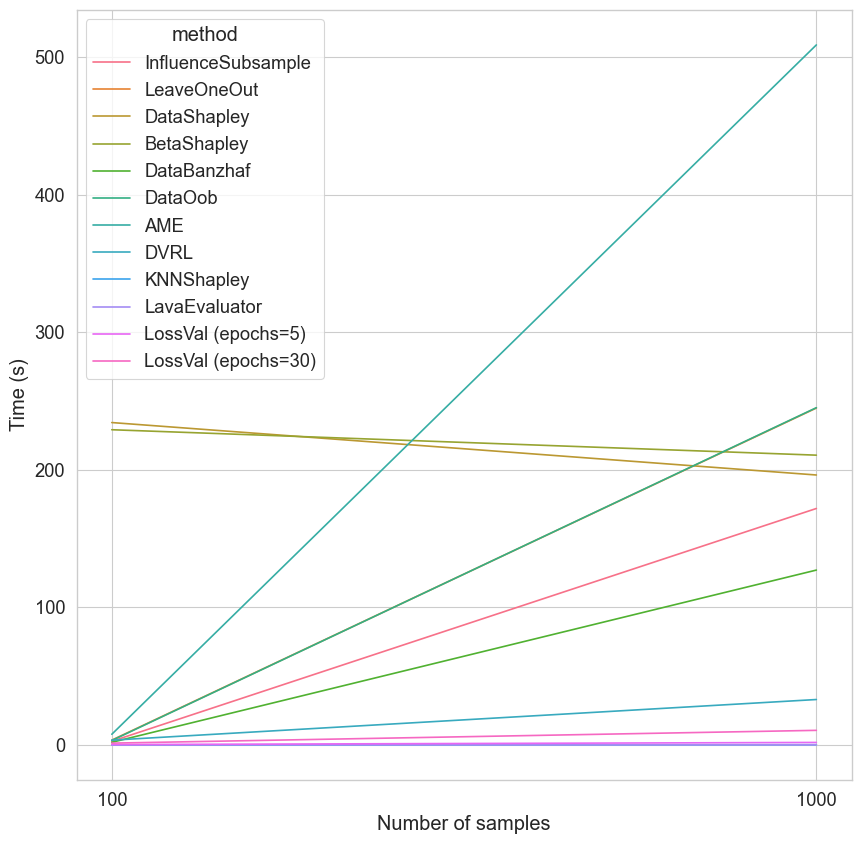

In [8]:
# Plot the time curves per methods over number of samples
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)

plt.figure(figsize=(10, 10))

sns.lineplot(data=timing_df, x="nr samples", y="time (s)", hue="method", errorbar=None)
plt.xlabel("Number of samples")
plt.ylabel("Time (s)")

# Set x ticks to the number of samples
plt.xticks(ticks=NR_OF_DATAPOINTS)

In [9]:
# To seconds again, then average over repetitions
timing_df = timing_df.groupby(["method", "nr samples"]).mean().reset_index()

timing_df

,method,nr samples,time (s)
0,AME,100,7.776302
1,AME,1000,508.983024
2,BetaShapley,100,229.184510
3,BetaShapley,1000,210.701400
4,DVRL,100,3.472799
5,DVRL,1000,33.025201
6,DataBanzhaf,100,1.908399
7,DataBanzhaf,1000,127.144614
8,DataOob,100,3.240400
9,DataOob,1000,245.226219


In [10]:
reformatted_df = timing_df.copy()
reformatted_df["time (s)"] = reformatted_df["time (s)"].apply(lambda x: time.strftime('%Mmin %Ss {:.0f}ms'.format(1000*(x-int(x))), time.gmtime(x))[1:])
reformatted_df

,method,nr samples,time (s)
0,AME,100,0min 07s 776ms
1,AME,1000,8min 28s 983ms
2,BetaShapley,100,3min 49s 185ms
3,BetaShapley,1000,3min 30s 701ms
4,DVRL,100,0min 03s 473ms
5,DVRL,1000,0min 33s 25ms
6,DataBanzhaf,100,0min 01s 908ms
7,DataBanzhaf,1000,2min 07s 145ms
8,DataOob,100,0min 03s 240ms
9,DataOob,1000,4min 05s 226ms


In [11]:
temp_df = reformatted_df.pivot(index="method", columns="nr samples", values="time (s)")
# temp_df["Method"] = temp_df.index

temp_df

nr samples,100,1000
method,,
AME,0min 07s 776ms,8min 28s 983ms
BetaShapley,3min 49s 185ms,3min 30s 701ms
DVRL,0min 03s 473ms,0min 33s 25ms
DataBanzhaf,0min 01s 908ms,2min 07s 145ms
DataOob,0min 03s 240ms,4min 05s 226ms
DataShapley,3min 54s 406ms,3min 16s 276ms
InfluenceSubsample,0min 02s 661ms,2min 51s 927ms
KNNShapley,0min 00s 21ms,0min 00s 160ms
LavaEvaluator,0min 00s 64ms,0min 00s 104ms


In [ ]:
# Create LaTeX table with the results
print(temp_df.to_latex(index=True, escape=False))